# Deep Learning Specialty Coffee Brew Profiling

This project is part of the Deep Learning course from the Master of Science Data Science (MSDS) programm at the CU Boulder.

Coffee that has exceptionally good quality is called specialty coffee. Beans that go into specialty coffee come from the best plants in the best growing regions of the planet. In contrast to commodity coffee, the roast profile of specialty coffee is typically light. However, creating a nice tasting cup of coffee is difficult. The key to achieve a good cup of coffee from specialty beans is consistency. Keeping everything as consistent as possible, changing one variable at a time, will ultimately lead to the best technique for brewing a delicious cup. 

Covering all aspects of specialty coffee in this write-up is not feasable. Only the basics needed to understand the project are described. The focus is on the deep learning task and techniques. If an interessted reader wants to learn more about coffee, a great resource is the YouTube Channel by [James Hoffmann](http://yt.com/jhoffmann). The technique I use for my pour-over coffee can also be found there: [A V60 technique for pour-over coffee.](https://yt.com)

To achieve the greatest possible amount of consistency, a special kind of scale is used. It has high precision (at least 0.1g accuracy) and also a timer function to display the amount of time that has passed since the beginning of the brewing process. A commonly used scale is the Hario Drip Scale. There are also more expensive smart scales available that record each brewing process in order to evaluate it. 

**The goal of this project is to make a Hario Drip Scale smart by using Deep Learning Algorithms.** For this, I recorded a video of the scale while brewing a pour-over coffee. Using neural networks for computer vision, this video is then used to create such a brew profile by reading the digits on the scale.

This image shows a sample frame from the input video:

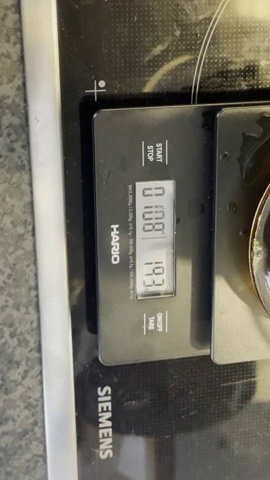

This video goes through the following steps to turn it into a brew profile:

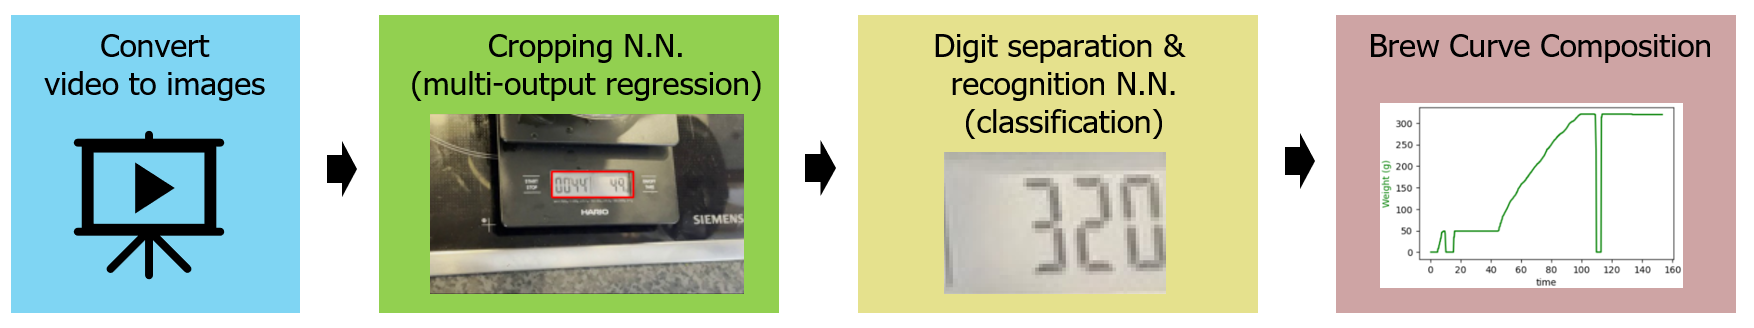

And this image shows the brew profile of this brew, made from the input video by the deep learning algorithms:

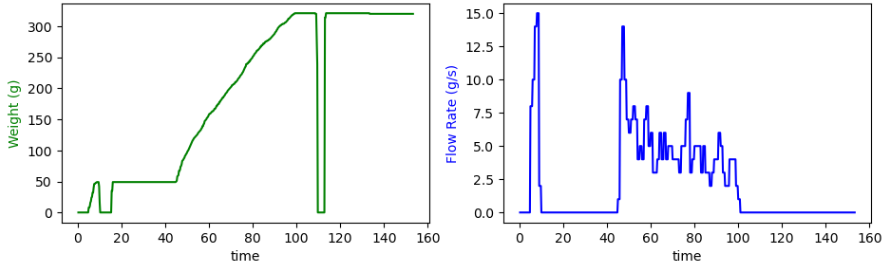

**Notes:** 
* The sample dataset that comes with this notebook is just a subset of the data used to train the algorithms. The goal is to give some guidance. If you want to re-use this notebook for your own purpose, make sure to create a thorough dataset on your own and adapt the code accordingly.
* Because I had to create the dataset and labels on my own, even the dataset that I used is not too big. Image labelling is a very time-consuming task, so please consider this when evaluating the model performance. Also, it leads to more appreciation for all those pre-labelled kaggle datasets available for free. 
* The final brewing profile above was creating using predictions from the deep learning models, but I had to manually correct some of them. The lack of data is one reason for that, but also more advanced computer vision algorithms should be used in the future in order to improve the performance of the model.

## 1) Preprocessing: Turn video into jpg

As a first preprocessing step, I scaled the resolution of the original video down and reduced the frame rate to 4fps. Then, the following code is used to turn the video file into multiple images.

In [ ]:
import cv2
# see https://web.archive.org/web/20161010175545/https://tobilehman.com/blog/2013/01/20/extract-array-of-frames-from-mp4-using-python-opencv-bindings/
# see also for fps setting: https://stackoverflow.com/questions/63666638/
vidcap = cv2.VideoCapture('brew01_test.mp4')
count = 0;
success,image = vidcap.read()
while success:
  success,image = vidcap.read()
  cv2.imwrite("brew01_img/frame%d.jpg" % count, image)     # save frame as JPEG file
  if cv2.waitKey(10) == 27:                     # exit if Escape is hit
      break
  count += 1

## 2) Train, Tune and Predict with Object Detector (Bounding Boxes)

After converting the video to images, the first deep learning task is to detect the display of the scale. This is not an easy task, as the video was recorded without a tripod. I manually labelled roughly 15% of the images using [LabelImg](https://github.com/heartexlabs/labelImg), resulting in a total of 83 labelled RGB images of size `[480, 270, 3]` (which is probably too few, but labelling is very time consuming). Looking at the bounding box coordinates in a plot, it can be seen how the display moves around the screen during the brewing process (Section 2.1). 

Then, a CNN algorithm is used to predict the coordinates of the bounding boxes (i.e. a multi-output regression task). Standard preprocessing methods are applied (such as scaling and resizing the images). Hyperparameter tuning is done via a manually implemented grid search. The prediction of the best model outputs are then used saved for later use (i.e. cropping the images to the scale display). For details see Section 2.2 and 2.3, respectively. 

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib import transforms
from scipy import ndimage
import glob
import os
from PIL import Image, ImageEnhance
import itertools

### 2.1) Exploratory Data Analysis and Preprocessing

In [50]:
# read labels from annotated image

def read_labels(img_path):
    # parse xml file with annotations
    tree = ET.parse(img_path)
    root = tree.getroot()
    fname = root[1].text
    xmin = int(root[6][4][0].text)
    ymin = int(root[6][4][1].text)
    xmax = int(root[6][4][2].text)
    ymax = int(root[6][4][3].text)
    return xmin, ymin, xmax, ymax

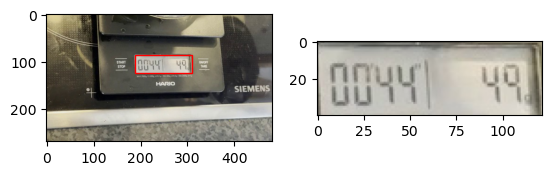

In [3]:
# show an annotated example from the training batch

def show_training_image(imgname="brew01_img_subset/frame184"):

    # read image and rotate 90 deg
    img = mpimg.imread(imgname + ".jpg")
    img = ndimage.rotate(img, 90)

    # parse xml file with annotations
    [xmin, ymin, xmax, ymax] = read_labels(imgname + ".xml")

    # Create figure and axes with image
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img)
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    
    # Show cropped image
    crp_img = img[ymin:ymax, xmin:xmax, :]
    ax2.imshow(crp_img) 
    
    plt.show()
    
show_training_image()

In [96]:
# show label distribution

df_train = pd.DataFrame(columns=['filename','label_path', 'xmin','ymin', 'xmax', 'ymax'])

# set filename list to df['filename']
df_train['filename'] = pd.Series([file for file in glob.glob(os.path.join('brew01_img_subset', '*'))]).str.replace('\\', '/', regex=False)
df_train = df_train[df_train.index % 2 == 0].reset_index(drop=True)
df_train['label_path'] = df_train['filename'].str.replace('jpg', 'xml', regex=False)

df_train['xmin'] = df_train['label_path'].apply(read_labels).apply(lambda x: x[0])
df_train['ymin'] = df_train['label_path'].apply(read_labels).apply(lambda x: x[1])
df_train['xmax'] = df_train['label_path'].apply(read_labels).apply(lambda x: x[2])
df_train['ymax'] = df_train['label_path'].apply(read_labels).apply(lambda x: x[3])

df_train.describe()

,xmin,ymin,xmax,ymax
count,83.000000,83.000000,83.000000,83.000000
mean,183.939759,89.457831,301.843373,129.168675
std,2.563103,4.249250,3.746484,3.783208
min,179.000000,82.000000,296.000000,122.000000
25%,182.000000,86.000000,299.000000,127.000000
50%,185.000000,88.000000,302.000000,128.000000
75%,186.000000,94.000000,305.000000,132.500000
max,188.000000,97.000000,310.000000,136.000000


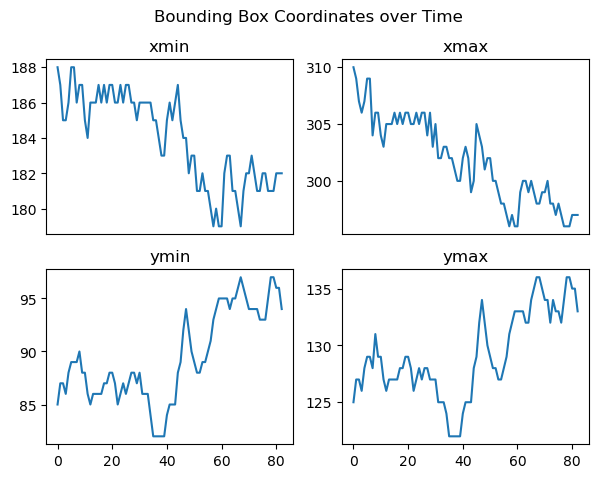

In [115]:
f, axs = plt.subplots(2, 2, figsize=(7,5))

f.suptitle("Bounding Box Coordinates over Time")

for i, ax in zip(range(4), axs.ravel()):
    if i==0:
        ax.plot(df_train["xmin"])
        ax.title.set_text("xmin")
        ax.get_xaxis().set_visible(False)
    elif i==1:
        ax.plot(df_train["xmax"])
        ax.title.set_text("xmax")
        ax.get_xaxis().set_visible(False)
    elif i==2:
        ax.plot(df_train["ymin"])
        ax.title.set_text("ymin")
    else:
        ax.plot(df_train["ymax"])
        ax.title.set_text("ymax")

In [4]:
# create data generator

BATCH_SIZE = 1
IN_HEIGHT = 270
IN_WIDTH = 480

gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.1,
)

gen_train = gen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col=['xmin', 'ymin', 'xmax', 'ymax'],
    subset='training',
    target_size=(IN_HEIGHT, IN_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='multi_output')

gen_valid = gen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col=['xmin', 'ymin', 'xmax', 'ymax'],
    subset='validation',
    target_size=(IN_HEIGHT, IN_WIDTH),
    batch_size=1,
    seed=42,
    class_mode='multi_output')

Found 75 validated image filenames.
Found 8 validated image filenames.


### 2.2) Define Model, Train and Tune

In [13]:
# Define model

BATCH_SIZE = 8
IN_HEIGHT = 270
IN_WIDTH = 480

LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
N_CONV_LAYERS = 4
N_FILTER_START = 8
MAX_POOL_SIZE = 4

def get_model(n_conv=N_CONV_LAYERS, n_filt_start=N_FILTER_START, max_pool=MAX_POOL_SIZE, dr=DROPOUT_RATE, lr=LEARNING_RATE, print_summary=False):

    mod = tf.keras.Sequential()

    for i in range(1,n_conv):
        mod.add(tf.keras.layers.Conv2D(filters=n_filt_start * 2**(i-1), kernel_size=(3,3), activation='relu'))
        mod.add(tf.keras.layers.MaxPooling2D(pool_size=(max_pool,max_pool)))
        mod.add(tf.keras.layers.Dropout(dr))

    mod.add(tf.keras.layers.Flatten())
    mod.add(tf.keras.layers.Dense(32, activation='relu'))
    mod.add(tf.keras.layers.Dense(4, activation='relu'))
    mod.build(input_shape=(BATCH_SIZE, IN_HEIGHT, IN_WIDTH, 3)) 
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    mod.compile(loss='mse', metrics=['mse'], optimizer=opt)

    if print_summary:
        print(mod.summary())
    return mod

In [15]:
# Train single epoch to show model architecture and verify training works
N_EPOCHS = 1
debug_mod = get_model(print_summary=True)
hist = debug_mod.fit_generator(gen_train, epochs = N_EPOCHS, validation_data = gen_valid, verbose=0)
debug_loss = debug_mod.evaluate(gen_valid, verbose=0)

print("Model loss: {:.2f}".format(debug_loss))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (8, 268, 478, 8)          224       
                                                                 
 max_pooling2d_3 (MaxPooling  (8, 67, 119, 8)          0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (8, 67, 119, 8)           0         
                                                                 
 conv2d_4 (Conv2D)           (8, 65, 117, 16)          1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (8, 16, 29, 16)          0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (8, 16, 29, 16)          

In [26]:
# model tuning
MAX_POOL_GRID = [2, 4]
N_CONV_GRID = [2, 4]
N_FILT_GRID = [4, 8]
DR_GRID = [0.2, 0.4]
LR_GRID = [0.001, 0.01]

best_model = debug_mod
best_loss = debug_loss
best_hp = None

for this_hp in itertools.product(N_CONV_GRID, N_FILT_GRID, MAX_POOL_GRID, DR_GRID, LR_GRID):
    this_mod = get_model(this_hp[0], this_hp[1], this_hp[2], this_hp[3], this_hp[4])
    hist = this_mod.fit_generator(gen_train, epochs = N_EPOCHS, validation_data = gen_valid, verbose=0)
    this_loss = this_mod.evaluate(gen_valid, verbose=0)
    if this_loss < best_loss:
        best_loss = this_loss
        best_model = this_model
        best_hp = this_hp

print("Best model loss: {:.2f}".format(best_loss))
print("Best model parameter: ", best_hp)

Best model loss: 73.66
Best model parameter:  (2, 8, 4, 0.4, 0.01)


### 2.3) Predict bounding boxes on full dataset

In [15]:
# Predict
df_test = pd.DataFrame(columns=['filename'])
df_test['filename'] = pd.Series([file for file in glob.glob(os.path.join('brew01_img', '*'))]).str.replace('\\', '/', regex=False)
df_test

gen_test = gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filename', 
    y_col=None,
    target_size=(IN_HEIGHT,IN_WIDTH),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

preds = best_model.predict(gen_test, verbose=1)
np.savetxt("preds.csv", preds, delimiter=";")
print("Predicitions saved...")

Predicitions saved...


## 3) Crop images, try prediction, create digits dataset

The next step of the deep learning pipeline is to use the prediction from the CNN regression model (bounding box prediction) to crop the raw images so that only the display of the scale is left. This, however, turned out to be a little complicated. The CNN regression model could not reach an accuracy good enough to simply use the predictions to crop the images. The main problem is the lack of labelled data due to time constraints, but also limited computation ressources for hyperparameter tuning play a role here. Hence, the model is just not good enough to be used out of the box. Instead, I went over the predictions and corrected some of them in order to proceed with the next step. This is definately something to improve in the future.

My initial plan was to use a pretrained OCR model to read the digits of the scale. For that, I tried to use tesseract, but as it can be seen in Section 3.2, this approach failed completely, even when omitting the timer and just focus on the displayed weight. So I decided to use a second CNN, this time for digit classification. The end of this section shows how the cropped images are then again turned into 4 sub images, each containing one possible digit of the scale. 

### 3.1) Read (predicted) bounding boxes

In [51]:
# read from annotation file

df_test = pd.DataFrame(columns=['filename','label_path', 'xmin','ymin', 'xmax', 'ymax'])
df_test['filename'] = pd.Series([file for file in glob.glob(os.path.join('brew01_img', '*'))]).str.replace('\\', '/', regex=False)
df_test = df_test[df_test.index % 2 == 0].reset_index(drop=True)
df_test['label_path'] = df_test['filename'].str.replace('jpg', 'xml', regex=False)

df_test['xmin'] = df_test['label_path'].apply(read_labels).apply(lambda x: x[0])
df_test['ymin'] = df_test['label_path'].apply(read_labels).apply(lambda x: x[1])
df_test['xmax'] = df_test['label_path'].apply(read_labels).apply(lambda x: x[2])
df_test['ymax'] = df_test['label_path'].apply(read_labels).apply(lambda x: x[3])

df_test.drop('label_path', axis=1).to_csv("brew01.csv", index=False)
df_test.drop('label_path', axis=1).head(5)

,filename,xmin,ymin,xmax,ymax
0,brew01_img/frame10.jpg,191,87,305,126
1,brew01_img/frame100.jpg,198,84,312,119
2,brew01_img/frame101.jpg,199,85,312,121
3,brew01_img/frame102.jpg,200,85,314,121
4,brew01_img/frame103.jpg,203,81,317,119


In [ ]:
# read from (corrected) prediction file

df_brew = pd.read_csv("brew01.csv")
df_brew['frame'] = df_brew['filename'].str.replace('brew01_img/frame', '', regex=False).str.replace('.jpg', '', regex=False).apply(pd.to_numeric)
df_brew.sort_values(by=['frame'], inplace=True)
df_brew.reset_index(drop=True, inplace=True)

### 3.2) Try tesseract OCR engine

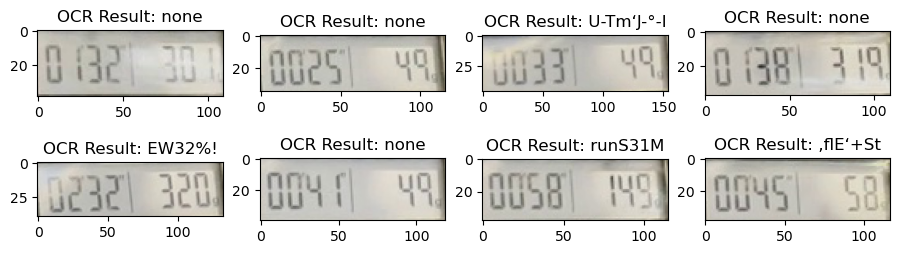

In [62]:
# show annotated examples from training batch and tesseract OCR result

import pytesseract

def show_cropped_samples(df):

    df = df.sample(n=8, random_state=42)
    
    # Create figure and axes with image
    f, axs = plt.subplots(2, 4, figsize=(11,3))
    
    for i, ax in zip(range(8), axs.ravel()):
        file = df.iloc[i].filename
        xmin = df.iloc[i].xmin
        ymin = df.iloc[i].ymin
        xmax = df.iloc[i].xmax
        ymax = df.iloc[i].ymax
        
        # read image and rotate 90 deg
        img = mpimg.imread(file)
        img = ndimage.rotate(img, 90)

        # Show cropped image
        crp_img = img[ymin:ymax, xmin:xmax, :]
        ax.imshow(crp_img) 
        ocr = pytesseract.image_to_string(crp_img).replace('\n', ' ').replace(' ','')
        ocr = "none" if len(ocr)==0 else ocr
        ax.title.set_text("OCR Result: " + ocr)
    
    plt.show()
    
show_cropped_samples(df_brew)

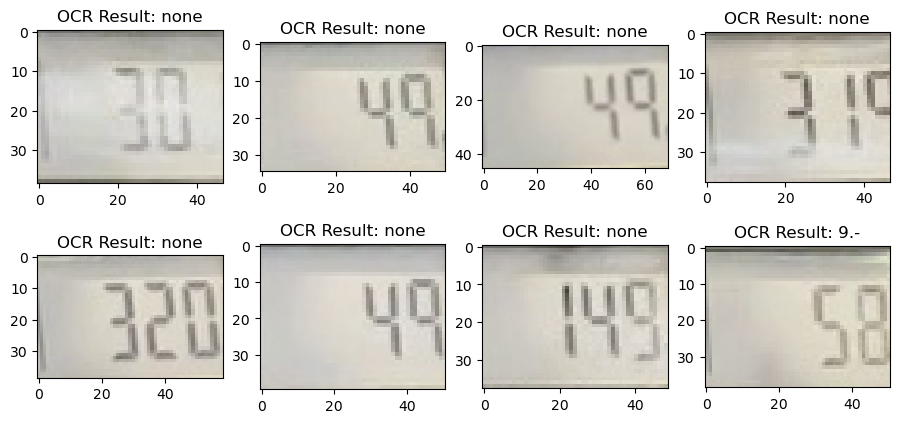

In [64]:
# show annotated examples from training batch and tesseract OCR result (only weight)

def show_cropped_samples_weight(df):

    df = df.sample(n=8, random_state=42)
    
    # Create figure and axes with image
    f, axs = plt.subplots(2, 4, figsize=(11,5))
    
    for i, ax in zip(range(8), axs.ravel()):
        file = df.iloc[i].filename
        xmin = df.iloc[i].xmin
        ymin = df.iloc[i].ymin
        xmax = df.iloc[i].xmax
        ymax = df.iloc[i].ymax
        
        xdist = round((xmax-xmin)/2) + xmin
        
        # read image and rotate 90 deg
        img = mpimg.imread(file)
        img = ndimage.rotate(img, 90)

        # Show cropped image
        crp_img = img[ymin:ymax, xdist:xmax-8, :]
        ax.imshow(crp_img) 
        ocr = pytesseract.image_to_string(crp_img).replace('\n', ' ').replace(' ','')
        ocr = "none" if len(ocr)==0 else ocr
        ax.title.set_text("OCR Result: " + ocr)
    
    plt.show()
    
show_cropped_samples_weight(df_brew)

### 3.3) Create digit dataset

In [77]:
# weight digit subset
#1 enhance images
#2 crop only digits
#3 save to folder
for index, row in df_brew.iterrows():
    file = row.filename
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    frame = row.frame

    xdist = round((xmax-xmin)/2) + xmin

    # read image and rotate 90 deg
    img = mpimg.imread(file)
    img = ndimage.rotate(img, 90)

    # crop image
    crp_img = img[ymin:ymax, xdist:xmax-6, :] # orig 7
    im = Image.fromarray(crp_img).convert('L')
    enhancer = ImageEnhance.Contrast(im)
    im_output = enhancer.enhance(3)
    im_output.thumbnail((120,30)) # make images same size
    weight_filename = "brew_weight/frame_"+str(frame)+".png"
    im_output.save(weight_filename)
    
    # single digit extraction
    img = mpimg.imread(weight_filename)*255
    _, xmax = img.shape # should be (120,30)
    xdif = xmax/4 # should be 30
    for i in range(4): # split image and save digit
        xmin = round(xdif*(i))+0
        xend = round(xdif*(i+1))+1 if i<3 else xmax
        crp_dig = img[:,xmin:xend]
        im = Image.fromarray(crp_dig).convert('L')
        im.save("brew_digits/frame_"+str(frame)+"_"+str(i)+".png")

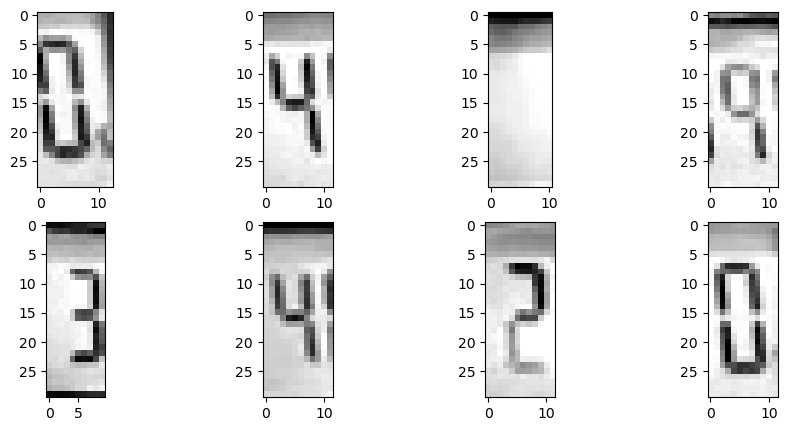

In [20]:
import random

def show_digit_samples(path):

    files=os.listdir(path)
    # Create figure and axes with image
    f, axs = plt.subplots(2, 4, figsize=(11,5))
    for i, ax in zip(range(8), axs.ravel()):
        file=random.choice(files)
        # read image
        img = Image.open(path+file)
        a = np.asarray(img)
        #img = ndimage.rotate(img, 90)
        ax.imshow(a, cmap="gray") 
    
    plt.show()
    
show_digit_samples("brew_digits/")

## 4) Train, Tune and Predict with Digit Reader

In this section, the CNN model to predict single digits of the scale is trained and tuned. The model architecture and tuning is done in a similar manner as section 2, but instead of a multi-output regression task, this is a classification task with 11 labels (0...9 digits + 10 as "empty/invalid").

Again, I manually labelled roughly 10% of the data (250 digits). This time, I pre-selected the digits to label to make sure I cover all digits in various aspects.

In [9]:
# Create tf dataset

BATCH_SIZE = 16
IN_HEIGHT = 30
IN_WIDTH = 30

df_digits = pd.read_csv("digits.csv")

gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.1,
)

gen_train = gen.flow_from_dataframe(
    dataframe=df_digits,
    x_col='filename',
    y_col='digit',
    subset='training',
    target_size=(IN_HEIGHT, IN_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='categorical')

gen_valid = gen.flow_from_dataframe(
    dataframe=df_digits,
    x_col='filename',
    y_col='digit',
    subset='validation',
    target_size=(IN_HEIGHT, IN_WIDTH),
    batch_size=1,
    seed=42,
    class_mode='categorical')

Found 225 validated image filenames.
Found 35 validated image filenames.


In [13]:
# Define model

BATCH_SIZE = 8
IN_HEIGHT = 30
IN_WIDTH = 30

LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
N_CONV_LAYERS = 4
N_FILTER_START = 8
MAX_POOL_SIZE = 2

def get_digit_model(n_conv=N_CONV_LAYERS, n_filt_start=N_FILTER_START, max_pool=MAX_POOL_SIZE, dr=DROPOUT_RATE, lr=LEARNING_RATE, print_summary=False):

    mod = tf.keras.Sequential()

    for i in range(1,n_conv):
        mod.add(tf.keras.layers.Conv2D(filters=n_filt_start * 2**(i-1), kernel_size=(3,3), activation='relu'))
        mod.add(tf.keras.layers.MaxPooling2D(pool_size=(max_pool,max_pool)))
        mod.add(tf.keras.layers.Dropout(dr))

    mod.add(tf.keras.layers.Flatten())
    mod.add(tf.keras.layers.Dense(32, activation='relu'))
    mod.add(tf.keras.layers.Dense(11, activation='softmax'))
    mod.build(input_shape=(BATCH_SIZE, IN_HEIGHT, IN_WIDTH, 3)) 
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    mod.compile(loss='categorical_crossentropy', optimizer=opt)

    if print_summary:
        print(mod.summary())
    return mod

get_digit_model(print_summary=True);

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (8, 28, 28, 8)            224       
                                                                 
 max_pooling2d_6 (MaxPooling  (8, 14, 14, 8)           0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (8, 14, 14, 8)            0         
                                                                 
 conv2d_7 (Conv2D)           (8, 12, 12, 16)           1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (8, 6, 6, 16)            0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (8, 6, 6, 16)            

In [14]:
# model tuning
MAX_POOL_GRID = [1, 2]
N_CONV_GRID = [2, 4]
N_FILT_GRID = [4, 8]
DR_GRID = [0.2, 0.4]
LR_GRID = [0.001, 0.01]

best_model = debug_mod
best_loss = debug_loss
best_hp = None

for this_hp in itertools.product(N_CONV_GRID, N_FILT_GRID, MAX_POOL_GRID, DR_GRID, LR_GRID):
    this_mod = get_model(this_hp[0], this_hp[1], this_hp[2], this_hp[3], this_hp[4])
    hist = this_mod.fit_generator(gen_train, epochs = N_EPOCHS, validation_data = gen_valid, verbose=0)
    this_loss = this_mod.evaluate(gen_valid, verbose=0)
    if this_loss < best_loss:
        best_loss = this_loss
        best_model = this_model
        best_hp = this_hp

print("Best model loss: {:.2f}".format(best_loss))
print("Best model parameter: ", best_hp)

print("Best model loss: 12.97\nBest model parameter:  (2, 4, 4, 0.2, 0.001)")

Best model loss: 12.97
Best model parameter:  (2, 4, 4, 0.2, 0.001)


In [16]:
# Predict
df_test = pd.DataFrame(columns=['filename'])
df_test['filename'] = pd.Series([file for file in glob.glob(os.path.join('brew01_img', '*'))]).str.replace('\\', '/', regex=False)
df_test

gen_test = gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filename', 
    y_col=None,
    target_size=(IN_HEIGHT,IN_WIDTH),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

preds = best_model.predict(gen_test, verbose=1)
np.savetxt("preds.csv", preds, delimiter=";")
print("Predicitions saved...")

Predicitions saved...


## 5) Load predictions, create brew profile

Finally, the digit predictions of the model are used to create the brew profile. However, again I had to manually change some of the erroneous predictions, but not as much as the cropped images. Also, I manually calculated the flow rate (g/s) in excel, as well set negative weight predictions (due to lifiting the dripper during the brewing process, details see V60 technique video) to 0.

In [83]:
df_profile = pd.read_csv("brew_profile.csv", delimiter=";")
df_profile.head(5)

,filename,digit_0,digit_1,digit_2,digit_3,total,time (s),rate (g/s)
0,brew_weight/frame_8.png,10,10,10,0,0,0.25,0
1,brew_weight/frame_9.png,10,10,10,0,0,0.50,0
2,brew_weight/frame_10.png,10,10,10,0,0,0.75,0
3,brew_weight/frame_11.png,10,10,10,0,0,1.00,0
4,brew_weight/frame_12.png,10,10,10,0,0,1.25,0


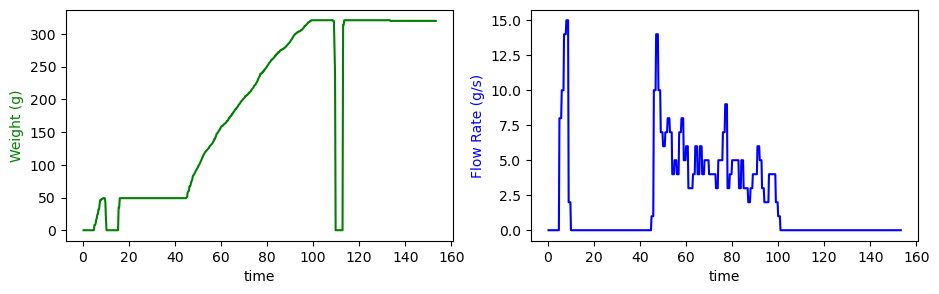

In [116]:
# plot brew profile

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,3))

ax1.plot(df_profile["time (s)"], df_profile["total"], 'g')
ax2.plot(df_profile["time (s)"], df_profile["rate (g/s)"], 'b')

ax1.set_xlabel('time')
ax1.set_ylabel('Weight (g)', color='g')
ax2.set_xlabel('time')
ax2.set_ylabel('Flow Rate (g/s)', color='b')

plt.show()

## 6) Conclusion

This project turned out to become a very complex computer vision task, consisting of various prepocessing steps and a pipeline of two deep learning models. One CNN model was used to predict bounding boxes (i.e. multi-output regression), the other one was used for digit recognition (i.e. multi-class classification). The goal was to turn a video recording of a coffee brewing scale while preparing a pour-over filter coffee into a brew profile showing the weight over time. 

This goal was achieved. However, I had to manually correct both of the models output in order to make a nice looking, reasonable brewing profile chart. The reason for that is mainly because of the limited availability of labelled data. For future improvements, more labeled data should be gathered. Also, using a tripod when recording the brew would help a lot, because the bounding box recognition model could become completely obsolete with that measure. In addition, some more advanced computer vision algorithms and techniques (such as YOLO) could be used to avoid the need for manually correcting the labels. Still, considering the limited time available for this project, it was still very fun and enjoyable. 

Happy brewing.